# NLP Bonus Excercise

**For this bonus excercise I have implemented different models with CountVectorizer and TfidfTransformers simply but it did not return good results. Therefore I have decided to train the model with XgBoost and CatBoost with pretrained Glove Embeddings. After training with both for different size of dimensions of Glove Embeddings, the best model was with 300 dimensions of embeddings applied with CatBoost. I have also applied some tunings. Since there were not all the words of our text in the Glove embeddings I have both applied by just passing those words and randomly generating the embeddings vector for those words and then I have trained the model with both taking the mean and sum of the embeddings vectors. Model with nean of the embeddings was better. I have also fine tunned the scale of normal random number generation. At the end passing the words that are not existed in embeddings were returning better result. Finally I have saved the test predictions to a TSV file to be submitted.**



## Mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Libraries

In [2]:
import pandas as pd
import json
from tqdm import tqdm
from gensim.parsing.preprocessing import remove_stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string 
from nltk.tokenize import word_tokenize
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn import  preprocessing 
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing the Train, Dev and Test 

In [3]:
# Opening JSON file
f_train = open('/content/drive/MyDrive/Data/NLP_Bonus_Data/train.jsonl')
f_dev = open('/content/drive/MyDrive/Data/NLP_Bonus_Data/dev.jsonl')
f_test = open('/content/drive/MyDrive/Data/NLP_Bonus_Data/test.jsonl')

id_lst = []
label_lst = []
text_lst = []

for i in tqdm(f_train.readlines()):
    id_lst.append(json.loads(i)["id"])
    label_lst.append(json.loads(i)["label"])
    text_lst.append(json.loads(i)["text"])

df_train = pd.DataFrame(columns=["id", "label", "text"])
df_train["id"] =  id_lst
df_train["label"] = label_lst
df_train["text"] = text_lst

id_lst = []
label_lst = []
text_lst = []

for i in tqdm(f_dev.readlines()):
    id_lst.append(json.loads(i)["id"])
    label_lst.append(json.loads(i)["label"])
    text_lst.append(json.loads(i)["text"])

df_dev = pd.DataFrame(columns=["id", "label", "text"])
df_dev["id"] =  id_lst
df_dev["label"] = label_lst
df_dev["text"] = text_lst

id_lst = []
text_lst = []

for i in tqdm(f_test.readlines()):
    id_lst.append(json.loads(i)["id"])
    text_lst.append(json.loads(i)["text"])

df_test = pd.DataFrame(columns=["id", "label", "text"])
df_test["id"] =  id_lst
df_test["text"] = text_lst

def prep(text):

    text = re.sub("[^a-zA-Z0-9 ]+", "", text.lower())    
    text = ' '.join(word for word in text.split() if word not in stop)
    return text

stop = stopwords.words('english')

df_train["text"] = df_train["text"].apply(lambda text: prep(text))
print("Train set has been preprocessed!")

df_dev["text"] = df_dev["text"].apply(lambda text: prep(text))
print("Dev set has been preprocessed!")

df_test["text"] = df_test["text"].apply(lambda text: prep(text))
print("Test set has been preprocessed!")

print("Preprocessing is done!")

100%|██████████| 6849/6849 [00:00<00:00, 104069.37it/s]


Train set has been preprocessed!
Dev set has been preprocessed!
Test set has been preprocessed!
Preprocessing is done!


In [4]:
print(df_train.isna().sum())
print(df_dev.isna().sum())
print(df_test.isna().sum())

id       0
label    0
text     0
dtype: int64
id       0
label    0
text     0
dtype: int64
id          0
label    6849
text        0
dtype: int64


world            33923
business         33200
sports           32272
sci/tech         29722
culture/arts      9200
wellness          9200
politics          9200
entertainment     9200
food/drink        5303
home/living       3070
environment       3062
crime             2682
media             2260
religion          2148
education         1840
Name: label, dtype: int64


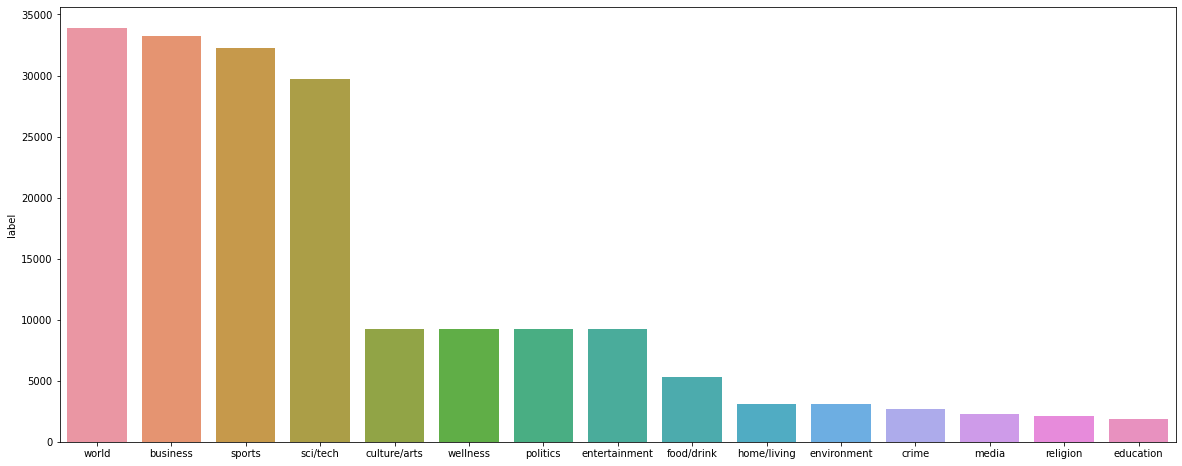

In [5]:
Classes =df_train['label'].value_counts()
print(Classes)
plt.figure(figsize=(20,8))
sns.barplot(Classes.index,Classes)

world            1170
business         1134
sports           1075
sci/tech          979
politics          400
wellness          400
culture/arts      400
entertainment     400
food/drink        231
home/living       134
environment       133
crime             117
media              98
religion           93
education          80
Name: label, dtype: int64


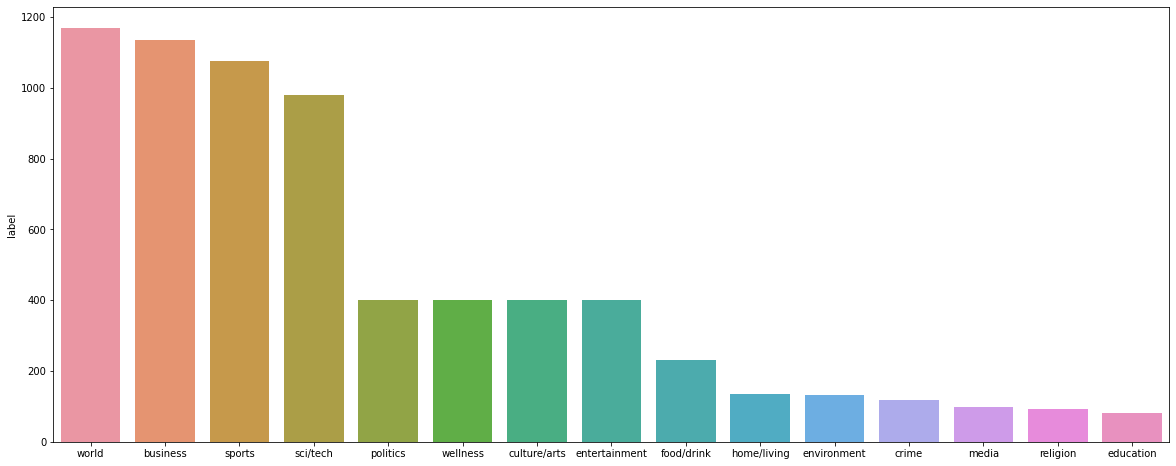

In [6]:
Classes =df_dev['label'].value_counts()
print(Classes)
plt.figure(figsize=(20,8))
sns.barplot(Classes.index,Classes)

## Try Models with CountVectorizer and TfidfTransformers

In [69]:
count_vect = CountVectorizer()
text_clf = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB())])
text_clf = text_clf.fit(df_train.text,  df_train.label)

predicted = text_clf.predict(df_dev.text)
print("Model accuracy is: %",(np.mean(predicted == df_dev.label))*100)

Model accuracy is: % 68.16189362945646


In [70]:
from sklearn.linear_model import SGDClassifier
count_vect = CountVectorizer()
text_clf = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf-svm', SGDClassifier(alpha=1e-3,  random_state=42))])
text_clf = text_clf.fit(df_train.text,  df_train.label)

predicted = text_clf.predict(df_dev.text)
print("Model accuracy is: %",(np.mean(predicted == df_dev.label))*100)

Model accuracy is: % 69.19929865575686


In [71]:
count_vect = CountVectorizer()
text_clf = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf-xgboost', XGBClassifier())])
text_clf = text_clf.fit(df_train.text,  df_train.label)

predicted = text_clf.predict(df_dev.text)
print("Model accuracy is: %",(np.mean(predicted == df_dev.label))*100)

Model accuracy is: % 63.09175920514319


## CatBoost Models with Pretrained Glove Embeddings

### Download and Unzip the Pretrained Glove Embeddings

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/
!unzip /content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/glove.6B.zip -d /content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/

### Define the Function to Get the Embeddings for Text and Implement the CatBoost

In [40]:
def calc_for_diff_emb_size(path,emb_size):
    embeddings_dict= {}
    f_glove = open(path)
    for line in tqdm(f_glove.readlines()):
        word, *vector = line.split()
        embeddings_dict[word] = np.array(vector, "float32")

    print("Embeddings dictionary has been created!")
    print()

    tokens_lst = []
    for text in tqdm(df_train.text):
        tokens_lst.append(text.split())

    df_train["tokenized_text"] = tokens_lst

    embeddings_list = []
    for tokens in tqdm(df_train.tokenized_text):
        emb_lst = []
        for word in tokens:
            try:
                emb_lst.append(embeddings_dict[word])
            except:
                pass
                #emb_lst.append(np.random.normal(scale=0.6, size=(emb_size, )))
        embeddings_list.append(np.mean(emb_lst,axis = 0))

    df_train["embeddings"] = embeddings_list

    print("Embeddings has been calculated for train set!")
    print()

    tokens_lst = []
    for text in tqdm(df_dev.text):
        tokens_lst.append(text.split())

    df_dev["tokenized_text"] = tokens_lst

    embeddings_list = []
    for tokens in tqdm(df_dev.tokenized_text):
        emb_lst = []
        for word in tokens:
            try:
                emb_lst.append(embeddings_dict[word])
            except:
                pass
        embeddings_list.append(np.mean(emb_lst,axis = 0))

    df_dev["embeddings"] = embeddings_list

    print("Embeddings has been calculated for dev set!")
    print()

    tokens_lst = []
    for text in tqdm(df_test.text):
        tokens_lst.append(text.split())

    df_test["tokenized_text"] = tokens_lst

    embeddings_list = []
    for tokens in tqdm(df_test.tokenized_text):
        emb_lst = []
        for word in tokens:
            try:
                emb_lst.append(embeddings_dict[word])
            except:
                pass
        embeddings_list.append(np.mean(emb_lst,axis = 0))

    df_test["embeddings"] = embeddings_list
    print("Embeddings has been calculated for test set!"),
    print()


    x_train =[]
    for emb in tqdm(df_train.embeddings):
        x_train.append(list(emb))

    x_dev = []
    for emb in tqdm(df_dev.embeddings):
       x_dev.append(list(emb))
    
    x_test = []
    for emb in tqdm(df_test.embeddings):
       x_test.append(list(emb))

    encode_label= preprocessing.LabelEncoder()
    encode_label.fit(df_train["label"])

    df_train["encoded_label"] = encode_label.transform(df_train["label"])
    df_dev["encoded_label"] = encode_label.transform(df_dev["label"])

    model = CatBoostClassifier(task_type="GPU")
    model.fit(df_train.embeddings,df_train.encoded_label)

    pred = model.predict(x_dev).flatten()
    test_pred = model.predict(x_test)
    test_pred_rencoded = encode_label.inverse_transform(test_pred)
    df_test_pred = df_test[["id"]]
    df_test_pred["Labels"] = test_pred_rencoded
    df_test_pred= df_test_pred.reset_index(drop = True)
    df_test_pred.to_csv("predictions_test.tsv",index = False,header = False, sep = "\t")


    print("The dev set accuracy is: %", (np.mean(pred == df_dev.encoded_label.to_list())*100))

### Catboost model with 50 Dimensional Pretrained Glove Embeddings

In [49]:
calc_for_diff_emb_size('/content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/glove.6B.50d.txt',50)

100%|██████████| 400000/400000 [00:05<00:00, 79862.27it/s]


Embeddings dictionary has been created!



100%|██████████| 186282/186282 [00:13<00:00, 14184.82it/s]


Embeddings has been calculated for train set!



100%|██████████| 6844/6844 [00:00<00:00, 18074.56it/s]


Embeddings has been calculated for dev set!



100%|██████████| 6849/6849 [00:00<00:00, 18862.98it/s]


Embeddings has been calculated for test set!



100%|██████████| 6844/6844 [00:00<00:00, 22644.87it/s]


Learning rate set to 0.188538
0:	learn: 1.9589708	total: 62.1ms	remaining: 1m 1s
1:	learn: 1.7637500	total: 123ms	remaining: 1m 1s
2:	learn: 1.6272387	total: 184ms	remaining: 1m 1s
3:	learn: 1.5244384	total: 243ms	remaining: 1m
4:	learn: 1.4490066	total: 313ms	remaining: 1m 2s
5:	learn: 1.3699619	total: 376ms	remaining: 1m 2s
6:	learn: 1.3085749	total: 436ms	remaining: 1m 1s
7:	learn: 1.2645438	total: 495ms	remaining: 1m 1s
8:	learn: 1.2192466	total: 560ms	remaining: 1m 1s
9:	learn: 1.1827103	total: 628ms	remaining: 1m 2s
10:	learn: 1.1485045	total: 691ms	remaining: 1m 2s
11:	learn: 1.1195846	total: 754ms	remaining: 1m 2s
12:	learn: 1.0963622	total: 814ms	remaining: 1m 1s
13:	learn: 1.0722640	total: 878ms	remaining: 1m 1s
14:	learn: 1.0521177	total: 940ms	remaining: 1m 1s
15:	learn: 1.0341242	total: 1s	remaining: 1m 1s
16:	learn: 1.0198900	total: 1.07s	remaining: 1m 1s
17:	learn: 1.0050361	total: 1.13s	remaining: 1m 1s
18:	learn: 0.9921910	total: 1.19s	remaining: 1m 1s
19:	learn: 0.980

### Catboost model with 100 Dimensional Pretrained Glove Embeddings

In [50]:
calc_for_diff_emb_size('/content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/glove.6B.100d.txt',100)

100%|██████████| 400000/400000 [00:08<00:00, 44471.20it/s]


Embeddings dictionary has been created!



100%|██████████| 186282/186282 [00:13<00:00, 13367.19it/s]


Embeddings has been calculated for train set!



100%|██████████| 6844/6844 [00:00<00:00, 17680.57it/s]


Embeddings has been calculated for dev set!



100%|██████████| 6849/6849 [00:00<00:00, 18613.03it/s]


Embeddings has been calculated for test set!



100%|██████████| 6844/6844 [00:00<00:00, 153678.80it/s]


Learning rate set to 0.188538
0:	learn: 1.9884981	total: 82.8ms	remaining: 1m 22s
1:	learn: 1.7864093	total: 174ms	remaining: 1m 26s
2:	learn: 1.6463953	total: 266ms	remaining: 1m 28s
3:	learn: 1.5500862	total: 367ms	remaining: 1m 31s
4:	learn: 1.4682531	total: 450ms	remaining: 1m 29s
5:	learn: 1.3936522	total: 546ms	remaining: 1m 30s
6:	learn: 1.3354102	total: 635ms	remaining: 1m 30s
7:	learn: 1.2878995	total: 721ms	remaining: 1m 29s
8:	learn: 1.2464625	total: 813ms	remaining: 1m 29s
9:	learn: 1.2087640	total: 908ms	remaining: 1m 29s
10:	learn: 1.1736942	total: 1s	remaining: 1m 30s
11:	learn: 1.1457427	total: 1.09s	remaining: 1m 29s
12:	learn: 1.1229779	total: 1.18s	remaining: 1m 29s
13:	learn: 1.1003085	total: 1.27s	remaining: 1m 29s
14:	learn: 1.0794448	total: 1.36s	remaining: 1m 29s
15:	learn: 1.0610570	total: 1.46s	remaining: 1m 29s
16:	learn: 1.0445111	total: 1.55s	remaining: 1m 29s
17:	learn: 1.0318173	total: 1.63s	remaining: 1m 28s
18:	learn: 1.0177514	total: 1.72s	remaining: 1

### Catboost model with 200 Dimensional Pretrained Glove Embeddings

In [54]:
calc_for_diff_emb_size('/content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/glove.6B.200d.txt',200)

100%|██████████| 400000/400000 [00:17<00:00, 22900.43it/s]


Embeddings dictionary has been created!



100%|██████████| 186282/186282 [00:10<00:00, 17262.40it/s]


Embeddings has been calculated for train set!



100%|██████████| 6844/6844 [00:00<00:00, 15855.63it/s]


Embeddings has been calculated for dev set!



100%|██████████| 6849/6849 [00:00<00:00, 16666.51it/s]


Embeddings has been calculated for test set!



100%|██████████| 6844/6844 [00:00<00:00, 17615.16it/s]


Learning rate set to 0.188538
0:	learn: 1.9881478	total: 154ms	remaining: 2m 33s
1:	learn: 1.7992239	total: 293ms	remaining: 2m 26s
2:	learn: 1.6694796	total: 441ms	remaining: 2m 26s
3:	learn: 1.5646461	total: 588ms	remaining: 2m 26s
4:	learn: 1.4871166	total: 749ms	remaining: 2m 28s
5:	learn: 1.4141758	total: 903ms	remaining: 2m 29s
6:	learn: 1.3511041	total: 1.05s	remaining: 2m 29s
7:	learn: 1.3035506	total: 1.2s	remaining: 2m 28s
8:	learn: 1.2600787	total: 1.36s	remaining: 2m 29s
9:	learn: 1.2219429	total: 1.52s	remaining: 2m 30s
10:	learn: 1.1883114	total: 1.68s	remaining: 2m 31s
11:	learn: 1.1584351	total: 1.85s	remaining: 2m 31s
12:	learn: 1.1337666	total: 2s	remaining: 2m 31s
13:	learn: 1.1090305	total: 2.15s	remaining: 2m 31s
14:	learn: 1.0884648	total: 2.29s	remaining: 2m 30s
15:	learn: 1.0712818	total: 2.45s	remaining: 2m 30s
16:	learn: 1.0524943	total: 2.62s	remaining: 2m 31s
17:	learn: 1.0368426	total: 2.77s	remaining: 2m 31s
18:	learn: 1.0241150	total: 2.91s	remaining: 2m 

### Catboost model with 300 Dimensional Pretrained Glove Embeddings

In [41]:
calc_for_diff_emb_size('/content/drive/MyDrive/Data/NLP_Bonus_Data/Glove/glove.6B.300d.txt',300)

100%|██████████| 400000/400000 [00:26<00:00, 15059.73it/s]


Embeddings dictionary has been created!



100%|██████████| 186282/186282 [00:13<00:00, 14176.42it/s]


Embeddings has been calculated for train set!



100%|██████████| 6844/6844 [00:00<00:00, 13412.87it/s]


Embeddings has been calculated for dev set!



100%|██████████| 6849/6849 [00:00<00:00, 14385.12it/s]


Embeddings has been calculated for test set!



100%|██████████| 6849/6849 [00:00<00:00, 35677.70it/s]


Learning rate set to 0.188538
0:	learn: 2.0017567	total: 200ms	remaining: 3m 20s
1:	learn: 1.8114468	total: 400ms	remaining: 3m 19s
2:	learn: 1.6754469	total: 611ms	remaining: 3m 23s
3:	learn: 1.5835695	total: 801ms	remaining: 3m 19s
4:	learn: 1.5002317	total: 1s	remaining: 3m 20s
5:	learn: 1.4308672	total: 1.23s	remaining: 3m 23s
6:	learn: 1.3672122	total: 1.46s	remaining: 3m 27s
7:	learn: 1.3183153	total: 1.69s	remaining: 3m 29s
8:	learn: 1.2799479	total: 1.9s	remaining: 3m 29s
9:	learn: 1.2424254	total: 2.13s	remaining: 3m 30s
10:	learn: 1.2131411	total: 2.34s	remaining: 3m 30s
11:	learn: 1.1821838	total: 2.56s	remaining: 3m 31s
12:	learn: 1.1567725	total: 2.79s	remaining: 3m 32s
13:	learn: 1.1301247	total: 3.02s	remaining: 3m 32s
14:	learn: 1.1088029	total: 3.25s	remaining: 3m 33s
15:	learn: 1.0881150	total: 3.49s	remaining: 3m 34s
16:	learn: 1.0683733	total: 3.72s	remaining: 3m 34s
17:	learn: 1.0496681	total: 3.95s	remaining: 3m 35s
18:	learn: 1.0338038	total: 4.16s	remaining: 3m 